In [23]:
# All the imports you will need in the whole lab
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB, ComplementNB
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from skimage.exposure import histogram
from skimage.morphology import skeletonize
from skimage import io
from skimage.filters import threshold_otsu, laplace
from skimage.color import rgb2gray
from skimage.util import invert
from skimage.segmentation import flood, flood_fill

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import csv


In [2]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)
    
    plt.bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')

In [3]:
def read_data(file_name):
    data = []
    with open(file_name, newline='') as csv_file:
        spamreader = csv.reader(csv_file, delimiter=' ', quotechar='|')
        for row in spamreader:
            data.append([float(element) for element in row[0].split(',')])
    return data

In [4]:
def read_test_data():
    test_data = read_data('validating_data.csv')

    test_data_true = []
    with open('./true_validating_data.csv', newline='') as csv_file:
        spamreader = csv.reader(csv_file, delimiter=' ', quotechar='|')
        for row in spamreader:
            test_data_true.append(float(row[0]))
            
    return test_data, test_data_true

In [165]:
def diacritic_segmentation(image):
    img = np.where(image > 0, 0, 1)
    horizontal_projection = np.sum(img, axis = 1)
    # got certain line
    baseline_location_index = horizontal_projection.argmax()
    
    diacritic_image = np.copy(image)
    previous_val = -1
    current_val = diacritic_image[baseline_location_index,:].argmin()
    
    while previous_val != current_val:
        diacritic_image = flood_fill(diacritic_image, (baseline_location_index, current_val), 255)
        previous_val = current_val
        current_val = diacritic_image[baseline_location_index,:].argmin()

    image_text = image - diacritic_image
    image_text = np.where(image_text > 0, 0, 1)

    return diacritic_image, image_text

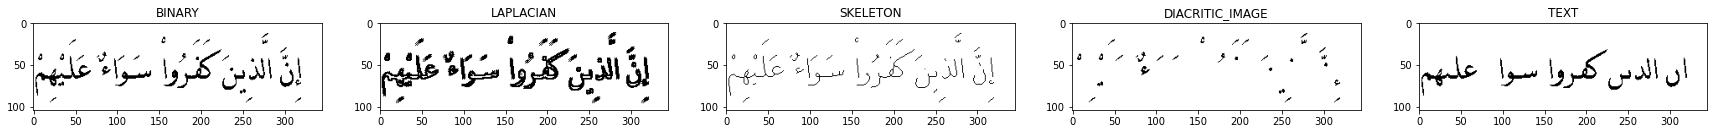

In [170]:
def preprocessing_image(img):
    '''
    DESCRIPTION:
    Preprocess an image.
        1. Grayscale
        2. OTSU Threshold
        3. Binarization
        4. Checking image binary is 0 or 255
        5. Laplacian filter
    
    RETURN:
    Preprocessd Image
    '''
    grayscale_image = rgb2gray(img)
    if grayscale_image.max() <= 1:
        grayscale_image = (grayscale_image * 255)
    grayscale_image = grayscale_image.astype(np.uint8)
    
    global_threshold = threshold_otsu(grayscale_image)
    binary_image = np.where(grayscale_image > global_threshold, 255, 0)
    # binary_image = grayscale_image > global_threshold
    
    image_histogram = np.asarray(histogram(binary_image, nbins=256))
    if image_histogram.argmax() <= 150:
        binary_image = 255 - binary_image
    binary_image = binary_image.astype(np.uint8)
    
    laplacian_image = cv2.convertScaleAbs(cv2.Laplacian(binary_image, cv2.CV_16S, ksize=3))
    laplacian_image = 255 - laplacian_image
    laplacian_image[laplacian_image == 255] = 1
    
    inverted_image = invert(binary_image)
    inverted_image[inverted_image == 255] = 1
    skeleton_image = skeletonize(inverted_image, method='zhang')
    skeleton_image = invert(skeleton_image)
    
    diacritic_image, text_image = diacritic_segmentation(binary_image)
    
    show_images([binary_image, laplacian_image, skeleton_image, diacritic_image, text_image], ['BINARY', 'LAPLACIAN', 'SKELETON', 'DIACRITIC_IMAGE', 'TEXT'])
    
    return binary_image, laplacian_image, skeleton_image, diacritic_image, text_image

# img = io.imread("..\\..\\data\\raw\\1\\0001.jpg")
img = io.imread("..\\..\\data\\raw\\2\\0191.jpg")
x = preprocessing_image(img)